# Applied Machine Learning: Assignment \#14

### Sheetal Parikh
EN.605.631.81<br>
May 10, 2021
***
***

## Problem 1

*Download the dataset, unzip and explore the file folders. Load the image dataset with training and testing grouped.*

*Display a few images. How many image channels are there?*

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import os
import struct
import sys

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import random
from random import shuffle

from sklearn import datasets, svm, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import  cross_validate, cross_val_score
from sklearn.metrics import confusion_matrix

print(f'TensorFlow version= {tf.__version__}')
print(f"CUDA available= {tf.test.gpu_device_name()}")

tf.test.is_built_with_cuda()

TensorFlow version= 2.3.0
CUDA available= 


False

In [2]:
#checking current directory
#print(os.getcwd() + "\n")

# change the current directory 
# to specified directory 
#os.chdir(r"C:\Users\Sheetal\Documents\Sheetal\datasets") 
#print(os.getcwd() + "\n")

ROOT_DIR = 'C:/Users/Sheetal/Documents/Sheetal/datasets/'

path_train = 'seg_train/seg_train/'
path_test = 'seg_test/seg_test/'
#path_pred = 'seg_pred/seg_pred'

import cv2

#print(f'CV2 version = {cv2.__version__}')

In [3]:
%%time

#loading images using code from homework description

IMGSIZE = (128, 128)

CNAMES = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

def load_images(_path_tr, _path_ts, _labels):
    X_tr, y_tr, X_ts, y_ts = [], [], [], []
    for label in _labels:
        path_tr = ROOT_DIR + _path_tr + label
        for f in sorted([_ for _ in os.listdir(path_tr) if _.lower().endswith('.jpg')]):
            X_tr += [cv2.resize(cv2.imread(os.path.join(path_tr,f)), IMGSIZE)]
            y_tr += [CNAMES.index(label)]
        path_ts = ROOT_DIR + _path_ts + label
        for f in sorted([_ for _ in os.listdir(path_ts) if _.lower().endswith('.jpg')]):
            X_ts += [cv2.resize(cv2.imread(os.path.join(path_ts,f)), IMGSIZE)]
            y_ts += [CNAMES.index(label)]
    return X_tr, y_tr, X_ts, y_ts

X_train, y_train, X_test, y_test = load_images(path_train, path_test, CNAMES)

Wall time: 55 s


In [4]:
#checking to make sure images loaded correctly and Image Size correct

print(f'N rows in X_train = {len(X_train)}')
print(f'N rows in X_test = {len(X_test)}')
print("")
print(f'N rows in y_train = {len(y_train)}')
print(f'N rows in y_test = {len(y_test)}')
print("")
print(f'Number of Classes: {len(CNAMES)}')
print ("Each image is of size: {}".format(IMGSIZE))

N rows in X_train = 14034
N rows in X_test = 3000

N rows in y_train = 14034
N rows in y_test = 3000

Number of Classes: 6
Each image is of size: (128, 128)


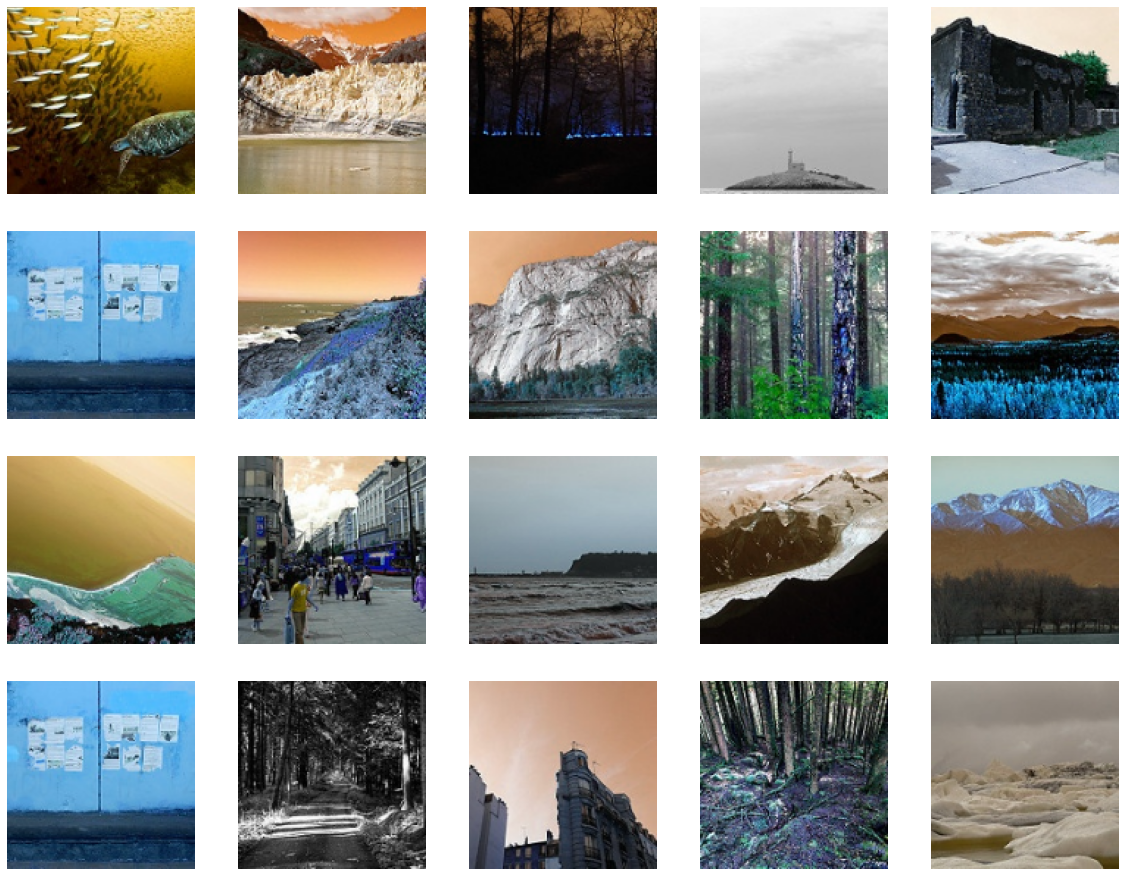

In [5]:
#displaying some images

plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X_train),20))) : 
    plt.subplot(5,5,n+1)
    plt.imshow(X_train[i])   
    plt.axis('off')

Number of Channels: 3


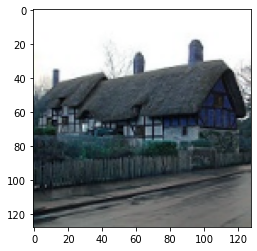

In [6]:
#checking image channels - expecting 3 since we have colored photos
n = random.randint(0,len(X_train))

f,ax = plt.subplots(1,1) 
ax.imshow(X_train[n])

img = X_train[n]

print(f'Number of Channels: {len(img.shape)}')

As expected, we have 3 channels since the images are in color and would have channels RGB.

In [7]:
X_train[0]

array([[[245, 247, 247],
        [245, 247, 247],
        [246, 248, 248],
        ...,
        [248, 248, 248],
        [246, 247, 247],
        [245, 247, 247]],

       [[244, 246, 246],
        [245, 247, 247],
        [245, 247, 247],
        ...,
        [248, 248, 248],
        [246, 247, 247],
        [245, 247, 247]],

       [[244, 246, 246],
        [244, 246, 246],
        [245, 247, 247],
        ...,
        [248, 248, 248],
        [246, 247, 247],
        [245, 247, 247]],

       ...,

       [[ 47,  49,  50],
        [ 55,  57,  58],
        [ 65,  67,  68],
        ...,
        [ 58,  61,  66],
        [ 38,  41,  46],
        [ 60,  63,  68]],

       [[ 65,  66,  67],
        [ 46,  48,  49],
        [ 67,  69,  70],
        ...,
        [ 33,  36,  41],
        [ 38,  41,  47],
        [ 45,  48,  53]],

       [[ 57,  59,  60],
        [ 52,  54,  55],
        [ 68,  70,  71],
        ...,
        [ 29,  32,  37],
        [ 38,  41,  46],
        [ 52,  55,  60]]

We can see from printing the training sample that the data is organized into 3 dimensional arrays for the 3 RGB channels. We can also see that numbers in the array span a large range of values. We can normalize the imageset so that it is between 0-1 in the next problem.

***
## Problem 2

*Convert the imageset to numpy array, such as the array size:(14034, 128, 128, 3).*

*Scale the imageset to [0-1].*

In [8]:
#converting imageset to numpy array
X_train = np.array(X_train, dtype = 'float32')
y_train = np.array(y_train, dtype = 'int32')

X_test = np.array(X_test, dtype = 'float32')
y_test = np.array(y_test, dtype = 'int32')

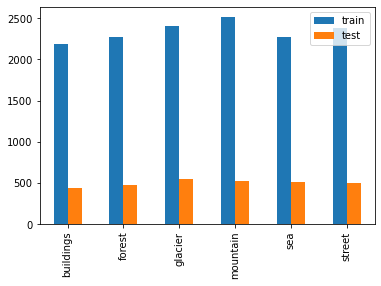

In [9]:
#displaying training and testing date
_, train_counts = np.unique(y_train, return_counts=True)
_, test_counts = np.unique(y_test, return_counts=True)
pd.DataFrame({'train': train_counts,'test': test_counts},index=CNAMES).plot.bar()
plt.show()

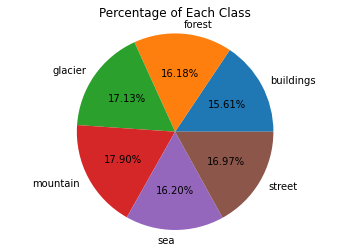

In [10]:
#displaying proportion of each class
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=CNAMES,
        autopct='%1.2f%%')
plt.axis('equal')
plt.title('Percentage of Each Class')
plt.show()

We can see that each the data is split fairly evenly within each class in the dataset. There are overall more images of mountains in the training dataset.  In the testing data it appears that glaciers appear the most frequently.

In [11]:
%%time

#scaling the imageset to [0-1]
X_train = X_train / 255
X_test = X_test / 255

#sanity check after scaling imageset to [0-1]
print(f'X_train Scaled Data - Min:{X_train.min()}')
print(f'X_train Scaled Data - Max:{X_train.max()}')
print(f'X_test Scaled Data - Min:{X_test.min()}')
print(f'X_test Scaled Data - Max:{X_test.max()}')

print("")

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train Scaled Data - Min:0.0
X_train Scaled Data - Max:1.0
X_test Scaled Data - Min:0.0
X_test Scaled Data - Max:1.0

X_train shape: (14034, 128, 128, 3)
X_test shape: (3000, 128, 128, 3)
y_train shape: (14034,)
y_test shape: (3000,)
Wall time: 28.9 s


We wanted to normalize the data so each pixel value was divided by 255.  Pixel values range from 0-255 for each channel so by dividing by 255, we would be normalizing the imageset. We can see above that now the values are between 0 and 1.

***
## Problem 3

*Create a convolutional neural network to train and report its performance on the testing portion of the dataset. 95% reclassification and 75% testing performance should be easily achievable without any hyperparameter tuning. (Hint: My model, which is similar to the model in module notebook, took around 10 minutes to train 10 epochs.)*


In [12]:
%%time

#CNN model
#using code from module notebook

tf.keras.backend.clear_session()
tf.random.set_seed(0)

cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = (128,128,3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(units=128, activation='relu'),
    
    tf.keras.layers.Dense(units=6, activation='softmax')
])

Wall time: 807 ms


In [14]:
#using code from module notebook

# Build the model
cnn.build(input_shape=(None, 128, 128, 3))

# Compile the model with the optimizer, loss function and metric
cnn.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

NUM_EPOCHS = 10

In [15]:
%%time

#training dataset
history = cnn.fit(X_train, y_train,
        epochs=NUM_EPOCHS,
        shuffle=True)

Epoch 1/10
439/439 [==============================] - 211s 481ms/step - loss: 0.9332 - accuracy: 0.6388
Epoch 2/10
439/439 [==============================] - 207s 472ms/step - loss: 0.6513 - accuracy: 0.7577
Epoch 3/10
439/439 [==============================] - 208s 473ms/step - loss: 0.5084 - accuracy: 0.8124
Epoch 4/10
439/439 [==============================] - 206s 469ms/step - loss: 0.4021 - accuracy: 0.8533
Epoch 5/10
439/439 [==============================] - 206s 469ms/step - loss: 0.3061 - accuracy: 0.8902
Epoch 6/10
439/439 [==============================] - 205s 467ms/step - loss: 0.2298 - accuracy: 0.9163
Epoch 7/10
439/439 [==============================] - 203s 463ms/step - loss: 0.1496 - accuracy: 0.9478
Epoch 8/10
439/439 [==============================] - 205s 468ms/step - loss: 0.1164 - accuracy: 0.9602
Epoch 9/10
439/439 [==============================] - 204s 464ms/step - loss: 0.0898 - accuracy: 0.9697
Epoch 10/10
439/439 [==============================] - 205s 467m

In [16]:
%%time
# Testing dataset
y_pred = np.argmax(cnn.predict(X_test), axis = -1)
print(f'Accuracy= {sum(y_pred==y_test)/len(y_test):.3f}', '\n')

Accuracy= 0.785 

Wall time: 17.3 s


In [ ]:
#installing seaborn - was getting an error that seaborn module didn't exist
#!{sys.executable} -m pip install seaborn

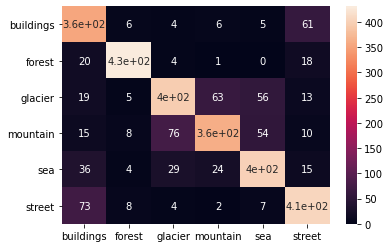

In [18]:
#displaying confusion matrix
import seaborn as sns

c_matrix = confusion_matrix(y_test, y_pred)

ax = plt.axes()
sns.heatmap(c_matrix, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=CNAMES, 
           yticklabels=CNAMES, ax = ax)
plt.show()

The model gets approximately 78% accuracy on the testing data. The model needs improvement in determining the difference between streets and buildings, mountains and glaciers, sea and glaciers, and the sea and mountains. We can see below if adding an regularization or drop-out features improves the performance

***
## Problem 4

*Add regularization and/or drop-out features to your CNN. Report your model's best performance.*

In [19]:
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2

regularizer_l2 = tf.keras.regularizers.l2(l=0.001)

In [20]:
%%time
#adding regularization and drop-out features
tf.keras.backend.clear_session()
tf.random.set_seed(0)

cnn2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = (128,128,3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), kernel_regularizer=regularizer_l2, activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), kernel_regularizer=regularizer_l2,activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(units=128,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(units=6, activation='softmax')
])


Wall time: 448 ms


In [21]:
# Build the model
cnn2.build(input_shape=(None, 128, 128, 3))

# Compile the model with the optimizer, loss function and metric
cnn2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

#NUM_EPOCHS = 10

In [23]:
%%time
#training
history2 = cnn2.fit(X_train, y_train,
        epochs=NUM_EPOCHS,
        shuffle=True)

Epoch 1/10
439/439 [==============================] - 217s 494ms/step - loss: 1.0899 - accuracy: 0.6011
Epoch 2/10
439/439 [==============================] - 139s 317ms/step - loss: 0.7940 - accuracy: 0.7161
Epoch 3/10
439/439 [==============================] - 132s 300ms/step - loss: 0.6652 - accuracy: 0.7710
Epoch 4/10
439/439 [==============================] - 135s 306ms/step - loss: 0.5847 - accuracy: 0.8025
Epoch 5/10
439/439 [==============================] - 131s 298ms/step - loss: 0.5361 - accuracy: 0.8191
Epoch 6/10
439/439 [==============================] - 127s 290ms/step - loss: 0.4988 - accuracy: 0.8345
Epoch 7/10
439/439 [==============================] - 127s 289ms/step - loss: 0.4410 - accuracy: 0.8565
Epoch 8/10
439/439 [==============================] - 130s 296ms/step - loss: 0.3998 - accuracy: 0.8746
Epoch 9/10
439/439 [==============================] - 132s 300ms/step - loss: 0.3782 - accuracy: 0.8794
Epoch 10/10
439/439 [==============================] - 127s 290m

Accuracy= 0.826 



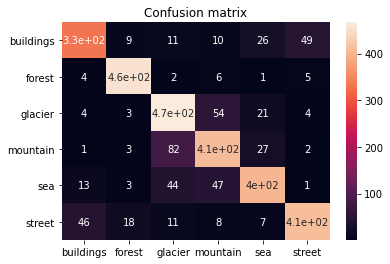

In [24]:
#testing dataset
y_pred2 = np.argmax(cnn2.predict(X_test), axis = -1)
print(f'Accuracy= {sum(y_pred2==y_test)/len(y_test):.3f}', '\n')

#displaying confusion matrix
c_matrix2 = confusion_matrix(y_test, y_pred2)
ax = plt.axes()
sns.heatmap(c_matrix2, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=CNAMES, 
           yticklabels=CNAMES, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

Adding the drop-out feature of 0.2 and the l2 regularization feature of 0.001 improved the testing accuracy to about 82%. The model improved in distinguishing between the sea and mountains and the sea and glaciers.

In [25]:
%%time
tf.keras.backend.clear_session()
tf.random.set_seed(0)

#adding drop-out and regularization features along with batch normalization

cnn3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = (128,128,3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), kernel_regularizer=regularizer_l2, activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3),kernel_regularizer=regularizer_l2, activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(units=6, activation='softmax')
])

Wall time: 543 ms


In [26]:
# Build the model
cnn3.build(input_shape=(None, 128, 128, 3))

# Compile the model with the optimizer, loss function and metric
cnn3.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

#NUM_EPOCHS = 10

In [28]:
%%time
#training

history3 = cnn3.fit(X_train, y_train,
        epochs=NUM_EPOCHS,
        shuffle=True)

Epoch 1/10
439/439 [==============================] - 179s 408ms/step - loss: 1.1817 - accuracy: 0.6095
Epoch 2/10
439/439 [==============================] - 186s 424ms/step - loss: 0.8580 - accuracy: 0.7304
Epoch 3/10
439/439 [==============================] - 169s 384ms/step - loss: 0.7423 - accuracy: 0.7723
Epoch 4/10
439/439 [==============================] - 170s 388ms/step - loss: 0.6815 - accuracy: 0.7959
Epoch 5/10
439/439 [==============================] - 167s 380ms/step - loss: 0.6367 - accuracy: 0.8065
Epoch 6/10
439/439 [==============================] - 168s 382ms/step - loss: 0.6045 - accuracy: 0.8145
Epoch 7/10
439/439 [==============================] - 166s 379ms/step - loss: 0.5747 - accuracy: 0.8261
Epoch 8/10
439/439 [==============================] - 167s 380ms/step - loss: 0.5496 - accuracy: 0.8366
Epoch 9/10
439/439 [==============================] - 178s 406ms/step - loss: 0.5334 - accuracy: 0.8414
Epoch 10/10
439/439 [==============================] - 169s 385m

Accuracy= 0.812 



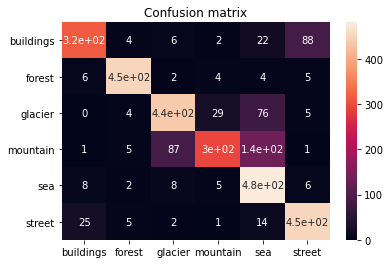

In [29]:
#import seaborn as sns

y_pred3 = np.argmax(cnn3.predict(X_test), axis = -1)
print(f'Accuracy= {sum(y_pred3==y_test)/len(y_test):.3f}', '\n')

c_matrix3 = confusion_matrix(y_test, y_pred3)
ax = plt.axes()
sns.heatmap(c_matrix3, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=CNAMES, 
           yticklabels=CNAMES, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

I also tried adding batch normalization along with the regularization and drop-out features. The model performed similarly but the accuracy was a little lower at around 81%.  The model primarily worsened in distinguishing between the sea and mountain and also between mountains and glaciers.  The model improved in distinguishing between buildings and streets and sea and glaciers.

***
## References

https://www.kaggle.com/puneet6060/intel-image-classification

https://stackoverflow.com/questions/60373943/how-to-determine-the-number-of-channels-in-image

https://www.kaggle.com/muhammetcakmak/basic-cnn-model-with-tensorflow

#https://www.kaggle.com/manishrathod/intel-image-classification-cnn-keras

https://towardsdatascience.com/loading-custom-image-dataset-for-deep-learning-models-part-1-d64fa7aaeca6

https://www.kdnuggets.com/2018/09/dropout-convolutional-networks.html

https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/

https://analyticsindiamag.com/everything-you-should-know-about-dropouts-and-batchnormalization-in-cnn/

https://www.machinecurve.com/index.php/2020/01/23/how-to-use-l1-l2-and-elastic-net-regularization-with-keras/

https://medium.com/intelligentmachines/convolutional-neural-network-and-regularization-techniques-with-tensorflow-and-keras-5a09e6e65dc7